# mesoSPIM PSF-analysis


## Experiment setup
- Mitutoyo BD 5X objective & MT-1 tube lens
- Photometrics Iris 15 camera
- 200-nm Fluorobright Yellow beads mounted in 2% agarose in CUBIC-R (n1.52) inside a 10x10x45 mm cuvette
- cuvette is immersed in chamber filled with CUBIC matching oil (n1.51)
- thickness of high-RI medium in detection path ~20 mm

### Tips and tricks
- LS tilt **and** tip relative to detection plane must be well aligned. Use the translation stage (mirror translation) for tilt alignment, and shims/adjustment screw for tip alignment. 
- For better LS tip/tilt alignment, go in and out of focus to visualize whole-field PSF degradation easier.
- **chamber** tip and tilt must be also aligned to advoid astigmatism

In [22]:
import numpy as np
import pandas as pd
from skimage.io import imread, find_available_plugins
import time

In [23]:
from psf import plotPSF, getCenters, getPSF

### Setup plotting

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [25]:
from ipywidgets import interact
from ipywidgets import IntSlider

### Define parameters

`windowUm = [15, 15, 15]` defines a "window" volume in microns in which only a single bead can exist (for the bead to be included in the analysis, the volume has to contain a single bright maximum).

In [26]:
# Full FOV 
MAG = 5 # Nominal magniciation of te objective
TL_f_mm = 200 # TL focal distante (200 or 180 mm)
eff_MAG = MAG * TL_f_mm/200
UmPerPxLat = 4.25/eff_MAG
pxPerUmLat = 1/UmPerPxLat
pxPerUmAx = 1.0 # between z-planes
windowUm = [15, 15, 15] # 
options = {'pxPerUmLat':pxPerUmLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = 700 #changed to abs, was relative: (0.05) 
options

{'pxPerUmLat': 1.1764705882352942,
 'pxPerUmAx': 1.0,
 'windowUm': [15, 15, 15],
 'thresh': 700}

In [27]:
datafolder = "D:\\benchtopData\\PSF\\2022-10-03-Mitu5X-TL-MT1-fbright200nm\\Excellent-galvo99.9Hz\\"
LENS_NAME = f"Mitutoyo BD {MAG}x/0.14 TLf{TL_f_mm}"
CAMERA = "Photometrics Iris 15"
sensor_dim_mm = (21.49, 12.61) # Iris 15
freq_Hz = 99.9
exp_ms = 20
experiment_key = f"{MAG}X_ETL-on" 
datafiles = {
    f"{MAG}X_ETL-on": datafolder + f"ETL-on.tif",
    f"{MAG}X_ETL-off": datafolder + f"ETL-off.tif",
}

### Load data

In [28]:
im = imread(datafiles[experiment_key], plugin='tifffile')[:50]
im.shape

(50, 5056, 2960)

### Computation

In [29]:
start_time = time.time()
beads, maxima, centers, smoothed = getCenters(im, options)
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

findBeads() done: 8237 found
centersM done
centerDists done
keepBeads() done: 4986 found
getCenters() done: 4986 found
Runtime:  81.50950741767883  s


In [30]:
start_time = time.time()
data = [getPSF(x, options) for x in beads]
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

Runtime:  9.594207286834717  s


In [31]:
centers = pd.DataFrame(centers, columns=['Z','Y','X'])

In [32]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]
PSF = PSF.join(centers)

### Inspect results

In [33]:
PSF.head()

,FWHMlat,FWHMax,Max,Z,Y,X
0,2.670981,4.492883,17806,24,2055,436
1,2.864184,4.478936,11911,30,2350,2619
2,3.064031,4.315871,13044,42,1982,1951
3,3.054543,4.786569,12561,10,591,1231
4,3.500532,4.423760,12416,36,2358,357


In [34]:
print('# Beads: ', len(PSF))
print('\nMedian lateral FWHM (+/- std): ', round(np.median(PSF['FWHMlat']),2), ' +/- ', round(PSF['FWHMlat'].std(),2), ' μm')
print(f"MIN, MAX lateral FWHM: {round(PSF['FWHMlat'].min(),2)}, {round(PSF['FWHMlat'].max(),2)} μm")
print('\nMedian axial FWHM  (+/- std): ', round(np.median(PSF['FWHMax']),2), ' +/- ', round(PSF['FWHMax'].std(),2), ' μm')
print(f"MIN, MAX axial FWHM: {round(PSF['FWHMax'].min(),2)}, {round(PSF['FWHMax'].max(),2)}, μm")

print('\nWatch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.')

# Beads:  4986

Median lateral FWHM (+/- std):  2.69  +/-  0.38  μm
MIN, MAX lateral FWHM: 2.07, 4.62 μm

Median axial FWHM  (+/- std):  4.21  +/-  0.34  μm
MIN, MAX axial FWHM: 2.62, 6.99, μm

Watch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.


### Plot axial FWHM vs. FOV

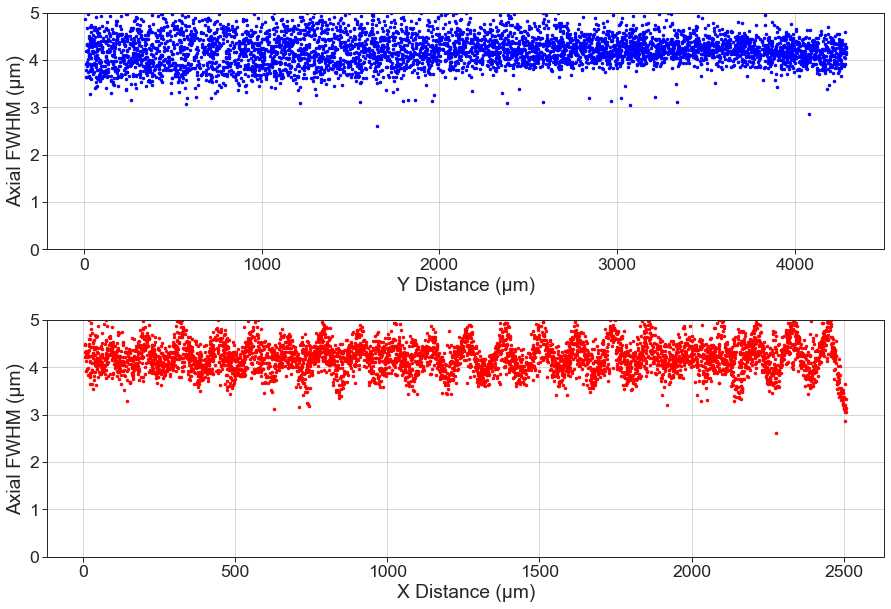

In [35]:
%matplotlib inline
YMIN, YMAX = 0, 5
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.b',ms=5)
subfigure0.set_ylim([YMIN,YMAX])
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Axial FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.r',ms=5)
subfigure1.set_ylim([YMIN,YMAX])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Axial FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

In [36]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-axialFWHM-along-axes.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-axialFWHM-along-axes.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

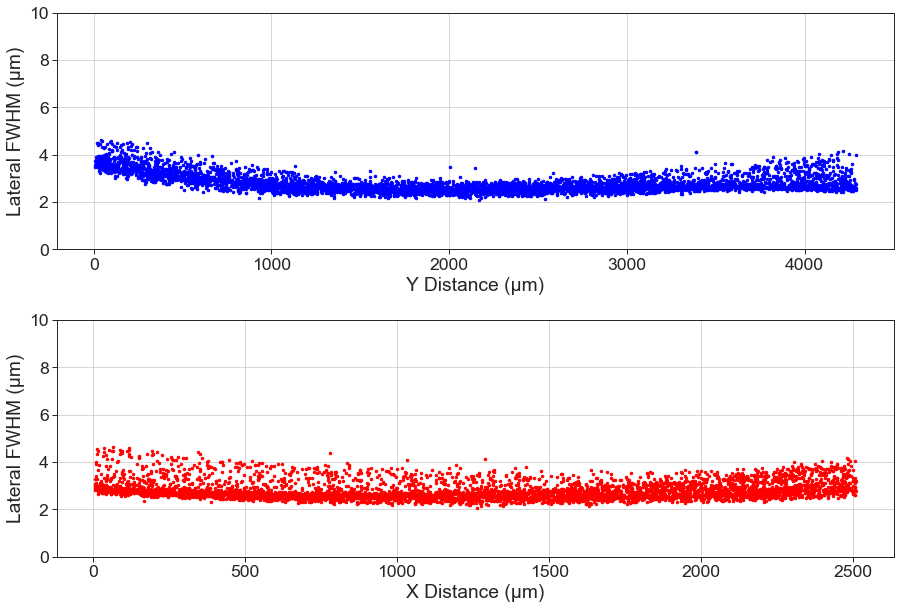

In [37]:
%matplotlib inline
YMIN, YMAX = 0, 10
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMlat'].tolist(),'.b',ms=5)
subfigure0.set_ylim([YMIN,YMAX])
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Lateral FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMlat'].tolist(),'.r',ms=5)
subfigure1.set_ylim([YMIN,YMAX])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Lateral FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

In [38]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-lateralFWHM-along-axes.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-lateralFWHM-along-axes.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

In [39]:
PSF.to_csv(datafolder + f'/{experiment_key}-20ms-99hz.csv')

## Sanity checks

### Plot max projection and detected beads

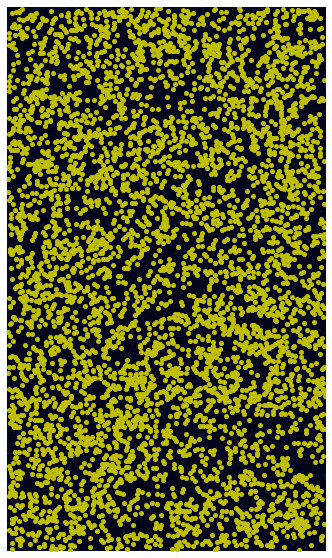

In [40]:
plt.figure(figsize=(10,10));
plt.imshow(smoothed);
plt.plot(PSF['X'].tolist(), PSF['Y'].tolist(), 'y.', ms=8);
plt.axis('off'); 

### Axial and lateral FWHM Histogram

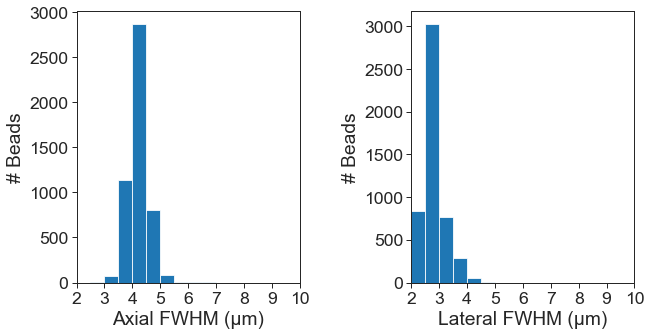

In [41]:
fig = plt.figure(figsize=(10,5))
subfigure0 = fig.add_subplot(121)
subfigure0.hist(PSF['FWHMax'].tolist(),2*8,range=(2,10))
subfigure0.set_xlim([2, 9])
subfigure0.set_xlabel('Axial FWHM (μm)')
subfigure0.set_xticks(range(2,11))
subfigure0.set_ylabel('# Beads')
subfigure1 = fig.add_subplot(122)
subfigure1.hist(PSF['FWHMlat'].tolist(),2*8,range=(2,10))
subfigure1.set_xlim([2, 9])
subfigure1.set_xticks(range(2,11))
subfigure1.set_xlabel('Lateral FWHM (μm)')
subfigure1.set_ylabel('# Beads')

plt.subplots_adjust(wspace = 0.5)

In [42]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-hist-axial-lateral.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-hist-axial-lateral.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

In [43]:
# manually exclude detections that are double-beads next to each other, see manual PSF check below
#exclude_IDs = [929, 2193]
#PSF_cleaned = PSF.drop(exclude_IDs)

### Overview Plots

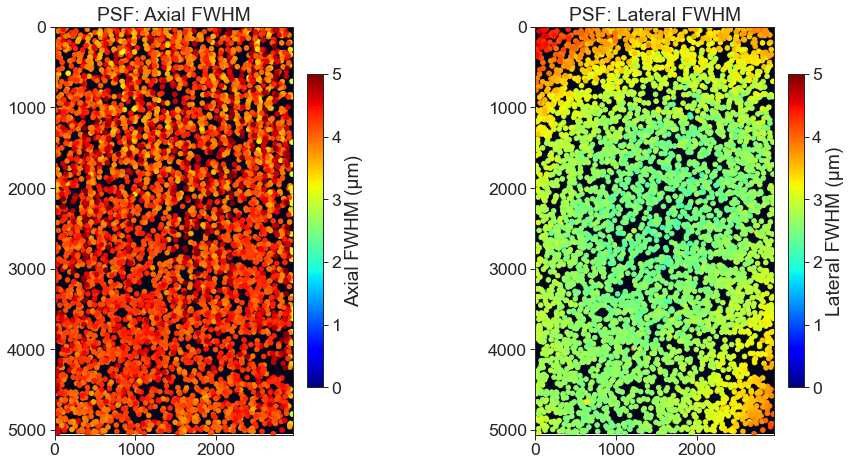

In [50]:
fig = plt.figure(figsize=(15,7.5));
cmap = 'jet'

subfigure0 = fig.add_subplot(121)
subfigure0.imshow(smoothed)
overlay0 = subfigure0.scatter(PSF['X'].tolist(), PSF['Y'].tolist(), c=PSF['FWHMax'].tolist(), cmap=cmap, vmin=0, vmax=5)
subfigure0.axis('on');
subfigure0.set_title('PSF: Axial FWHM')
cbar0 = plt.colorbar(overlay0,fraction=0.044, pad=0.04)
cbar0.set_label('Axial FWHM (μm)')


subfigure1 = fig.add_subplot(122)
subfigure1.imshow(smoothed);
overlay1 = subfigure1.scatter(PSF['X'].tolist(), PSF['Y'].tolist(), c=PSF['FWHMlat'].tolist(), cmap=cmap, vmin=0, vmax=5);
subfigure1.axis('on');
subfigure1.set_title('PSF: Lateral FWHM')
cbar1 = plt.colorbar(overlay1,fraction=0.044, pad=0.04)
cbar1.set_label('Lateral FWHM (μm)')

plt.subplots_adjust(wspace = 0.35)

In [51]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-Comparision-XYplot-jet.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-Comparision-XYplot-jet.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

## Plot XYZ projections of selected PSFs and fit

In [46]:
centerPSFs = PSF[PSF.FWHMlat > 4.5]
centerPSFs.head()

,FWHMlat,FWHMax,Max,Z,Y,X
4492,4.507657,3.909373,5354,43,157,62
4825,4.575154,3.904442,4304,43,53,45
4834,4.553012,3.959875,4845,33,238,15
4844,4.622231,4.045653,4454,29,47,80
4873,4.519412,4.392542,5140,9,108,105


In [47]:
len(centerPSFs)

6

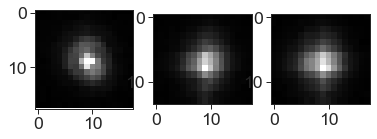

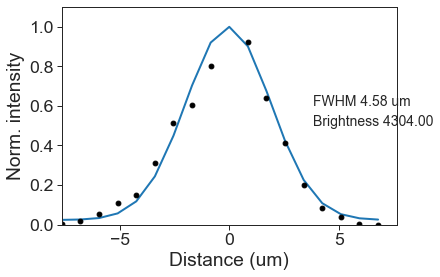

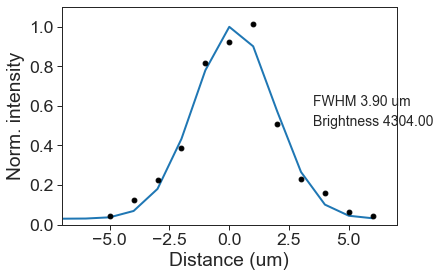

In [48]:
# Plot PSF with known ID
beadInd = 4825
average = beads[beadInd]

fig, _axs = plt.subplots(nrows=1, ncols=3)
axs = _axs.flatten()

XYview = axs[0].imshow(average.mean(axis=0), cmap='gray');
XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
plt.show()

plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()

In [49]:
fig = plt.figure()

def update(w = 50):
    beadInd = w
    average = beads[beadInd]
    
    fig, _axs = plt.subplots(nrows=1, ncols=3)
    axs = _axs.flatten()

    XYview = axs[0].imshow(average.mean(axis=0));
    XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx);
    YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx);
    plt.show()
    plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
    plt.show()
    plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
    plt.show()

interact(update, w=IntSlider(min=0,max=len(PSF)-1,step=1,value=0,continuous_update=False));

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=0, continuous_update=False, description='w', max=4985), Output()), _dom_…